In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AbstractRNNCell
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import activations
from tensorflow.keras import Input

import numpy as np

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt

If you want to check if op is run on GPU set following option to be true and run toy example

In [0]:
tf.debugging.set_log_device_placement(False)

You can skip the cell below since Eager Execution is by default enabled

In [5]:
tf.executing_eagerly()

True

In [0]:
def binarize(images):
    return (np.random.uniform(size=images.shape) < images).astype('float32')

In [0]:
def prepare_mnist_features_and_labels(x, y):
    pass

def mnist_dataset(bsize=100, shuffle_buffer_size=1000):
    (x, y), _ = tf.keras.datasets.mnist.load_data()
    x = binarize(np.array(x / 255.0, dtype=np.float32))
    x = np.expand_dims(x, -1)
    #import copy
    #y = copy.deepcopy(x)

    from sklearn.model_selection import train_test_split
    X, Xval, Y, Yval = train_test_split(x, y, test_size=0.2, random_state=1)

    n_tr = X.shape[0]
    n_te = Xval.shape[0]

    #trds = tf.data.Dataset.from_tensor_slices((X, Y))
    trds = tf.data.Dataset.from_tensor_slices((X, X))
    #trds = trds.map(prepare_mnist_features_and_labels)
    trds = trds.take(n_tr).shuffle(shuffle_buffer_size).batch(bsize)

    #teds = tf.data.Dataset.from_tensor_slices((Xval, Yval))
    teds = tf.data.Dataset.from_tensor_slices((Xval, Xval))
    #trds = trds.map(prepare_mnist_features_and_labels)
    teds = teds.take(n_te).shuffle(shuffle_buffer_size).batch(bsize)

    return trds, teds

train_dataset, val_dataset = mnist_dataset(16)


In [0]:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import nn

'''
grayscale은 쉬운데
grayscale부터 해보자!
rgb는 내생각에는
utils에
N, H, W, C --> N,H,W*C로 만들어야할듯
반대 operation도! skew참조

'''

class MaskedConv2D(layers.Conv2D):
    def __init__(self, *args, mask='B', n_channel=3, mono=False, **kwargs):
        super(MaskedConv2D,self).__init__(*args,**kwargs)
        self.mask_type = mask
        self.mask = None
        self.trainable=True
    
    def build(self, input_shape):
        super(MaskedConv2D, self).build(input_shape)
        if self.data_format == 'channel_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                           'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.mask = np.ones(kernel_shape)

        self.mask[kernel_shape[0]//2,kernel_shape[1]//2 + (self.mask_type == 'B'):,:,:] = 0
        self.mask[kernel_shape[0]//2+1:,:,:,:] = 0

        self.mask = tf.convert_to_tensor(self.mask, dtype=tf.float32)
        self.mask = tf.Variable(self.mask, trainable=False)
        #self.kernel = tf.Variable(self.kernel * self.mask)
        self.built = True
    
    #def call(self, inputs):
    #  return super(MaskedConv2D, self).call(inputs)
  
    '''
    the code snippet below is taken from tf.keras convolutional.py
    '''
    def call(self, inputs):
        outputs = self._convolution_op(inputs, self.kernel * self.mask)

        if self.use_bias:
            if self.data_format == 'channels_first':
                if self.rank == 1:
                    # nn.bias_add does not accept a 1D input tensor.
                    bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                    outputs += bias
                else:
                    outputs = nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    


In [0]:
def conv_block(filters, kernel_size, mask=None):
    inputs = tf.keras.Input(shape=(28,28,filters))
    x = MaskedConv2D(filters, kernel_size, n_channel=filters, mask=mask, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.activations.relu(x)
    return tf.keras.Model(inputs, outputs, name='conv_block')


In [0]:
class PixelCNN(tf.keras.Model):
    def __init__(self, hidden_dims, width, height, channels, layers, *args, **kwargs):
        super(PixelCNN, self).__init__(*args, **kwargs)

        self.conv7_7 = MaskedConv2D(hidden_dims, (7,7),n_channel=1, mask='A', padding='same')
        if layers > 1:
            self.conv3_3 = [conv_block(hidden_dims, (3,3), mask='B') for _ in range(layers)]
        else:
            self.conv3_3 = [conv_block(hidden_dims, (3,3), mask='B')]

        self.conv1_1 = Conv2D(32, (1,1), padding='same', activation='relu')
        self.conv_last = Conv2D(1, (1,1), padding='same')

    def call(self, inputs):
        x = self.conv7_7(inputs)
        for conv in self.conv3_3:
            x = conv(x)

        x = self.conv1_1(x)
        x = self.conv_last(x)
        return activations.sigmoid(x)

  

In [0]:
HIDDEN_DIMS = 128
LAYERS = 15
HEIGHT, WIDTH = (28,28)
CHANNELS = 1

pixelcnn = PixelCNN(HIDDEN_DIMS,WIDTH,HEIGHT,CHANNELS,LAYERS)

It seems like TF Eagermode tracks variables once model is built and build() is called when model is actually called

In [0]:
pixelcnn.compile(optimizer=tf.optimizers.RMSprop(0.001),
              loss='binary_crossentropy',
              )


In [11]:
print(pixelcnn.metrics_names)

['loss']


In [0]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./model/model_{epoch}.h5', mode='min', monitor='val_loss')
]

In [12]:
history = pixelcnn.fit(train_dataset, verbose=1, validation_data=val_dataset, epochs=10) #, callbacks=callbacks) 

Epoch 1/10
3000/3000 [==============================] - 319s 106ms/step - loss: 0.1326 - val_loss: 0.0000e+00
Epoch 2/10
3000/3000 [==============================] - 314s 105ms/step - loss: 0.1122 - val_loss: 0.1149
Epoch 3/10
3000/3000 [==============================] - 314s 105ms/step - loss: 0.1101 - val_loss: 0.1095
Epoch 4/10
3000/3000 [==============================] - 314s 105ms/step - loss: 0.1090 - val_loss: 0.1093
Epoch 5/10
3000/3000 [==============================] - 313s 104ms/step - loss: 0.1082 - val_loss: 0.1089
Epoch 6/10
3000/3000 [==============================] - 314s 105ms/step - loss: 0.1076 - val_loss: 0.1089
Epoch 7/10
3000/3000 [==============================] - 313s 104ms/step - loss: 0.1071 - val_loss: 0.1080
Epoch 8/10
3000/3000 [==============================] - 313s 104ms/step - loss: 0.1067 - val_loss: 0.1078
Epoch 9/10
3000/3000 [==============================] - 313s 104ms/step - loss: 0.1064 - val_loss: 0.1078
Epoch 10/10
3000/3000 [===================

In [13]:
pixelcnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masked_conv2d (MaskedConv2D) multiple                  12672     
_________________________________________________________________
conv_block (Model)           (None, 28, 28, 128)       295552    
_________________________________________________________________
conv_block (Model)           (None, 28, 28, 128)       295552    
_________________________________________________________________
conv_block (Model)           (None, 28, 28, 128)       295552    
_________________________________________________________________
conv_block (Model)           (None, 28, 28, 128)       295552    
_________________________________________________________________
conv_block (Model)           (None, 28, 28, 128)       295552    
_________________________________________________________________
conv_block (Model)           (None, 28, 28, 128)       29

Another way of training

Using custom train_step decorated with @tf.function

In [0]:
#optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
optimizer = tf.optimizers.RMSprop(learning_rate=0.001)

Checkpoint's constructor accepts keyword arguments whose values are types that contain trackable state, such as tf.keras.optimizers.Optimizer implementations, tf.Variable, tf.keras.Layer implementations, or tf.keras.Model implementations. It saves these values with a checkpoint, and maintains a save_counter for numbering checkpoints.

In [0]:
ckpt = tf.train.Checkpoint(pixelrnn=pixelrnn, optimizer=optimizer)

Equivalent to tf.train.latest_checkpoint(directory) where directory is the constructor argument to CheckpointManager.

In [0]:
checkpoint_path = './checkpoint/train'
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [0]:
@tf.function
def train_step(inputs, targets):
  
    #if len(targets.shape) > 2:
    #  width = targets.shape[-2]
    #  targets = tf.reshape(targets, [-1, width*width])
  
    with tf.GradientTape() as tape:    
        logits_ = pixelrnn(inputs)
        #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits_))
        bce = tf.keras.losses.BinaryCrossentropy()
        loss = bce(targets, logits_)
    grads = tape.gradient(loss, pixelrnn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pixelrnn.trainable_variables))
  
    return loss

In [0]:
import random
EPOCHS = 1
BATCH_SIZE = 16
loss_trace = []
import time
for epoch in range(EPOCHS):
  
    total_loss = 0.0
    i=0
    epoch_start = time.time()
    for x,y in train_dataset:
        start=time.time()
        loss = train_step(x,y)
    
        total_loss += loss
        i += 1
    
        if i % 100 == 0:
            if i % 500 == 0:
                print('{}% complete'.format(i/30))
        else:
            print('{}% complete'.format(i/30) ,end=' ')
        
    epoch_elapsed = time.time() - epoch_start
    print("epoch {} : elapsed: {}".format(epoch,epoch_elapsed))
    print("epoch {} : loss: {}".format(epoch,total_loss))
  
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
  
    loss_trace.append(total_loss)

3.3333333333333335% complete 6.666666666666667% complete 10.0% complete 13.333333333333334% complete 16.666666666666668% complete
20.0% complete 23.333333333333332% complete 26.666666666666668% complete 30.0% complete 33.333333333333336% complete
36.666666666666664% complete 40.0% complete 43.333333333333336% complete 46.666666666666664% complete 50.0% complete
53.333333333333336% complete 56.666666666666664% complete 60.0% complete 63.333333333333336% complete 66.66666666666667% complete
70.0% complete 73.33333333333333% complete 76.66666666666667% complete 80.0% complete 83.33333333333333% complete
86.66666666666667% complete 90.0% complete 93.33333333333333% complete 96.66666666666667% complete 100.0% complete
epoch 0 : elapsed: 720.024587392807
epoch 0 : loss: 709.5159301757812


In [0]:
'''

clone keras model

config = model.get_config()
weights = model.get_weights()

new_model = keras.Model.from_config(config)
new_model.set_weights(weights)
'''

In [0]:
epoch_to_load = 5
chkpoint_path = '/content/drive/My Drive/Colab Notebooks/pixelrnn/model_{}.h5'.format(epoch_to_load)
pixelrnn_loaded = keras.models.load_model(chkpoint_path)

In [0]:
'''
#if you store model in .ckpt format
latest = tf.train.latest_checkpoint('/content/drive/My Drive/Colab Notebooks/pixelrnn/')
# Create a new model instance
pixelrnn_loaded = PixelRNN(HIDDEN_DIMS,WIDTH,HEIGHT,CHANNELS,LAYERS)

# Load the previously saved weights
pixelrnn_loaded .load_weights(latest)
'''

In [0]:
'''
this is also possible
new_model = keras.models.model_from_json(json_config)
new_model.load_weights('path_to_my_weights.h5')
'''

In [0]:
import time

def generate(model, batch=100):
    
    generated_samples = np.zeros((batch,28,28,1), dtype=np.float32)
    beg = time.time()
    for i in range(28):
        for j in range(28):
            generated_samples[:,i,j,0] = binarize(model(generated_samples).numpy())[:,i,j,0]
      
    elapsed = time.time() - beg
    print("time taken for generation: {}".format(elapsed))
    return generated_samples

In [0]:
import PIL
import os
def save_images(images, height, width, n_row, n_col, directory="./", prefix="sample", epoch=1):
    images = images.reshape((n_row, n_col, height, width))
    images = images.transpose(1, 2, 0, 3)
    images = images.reshape((height * n_row, width * n_col))

    filename = '%s_%s.jpg' % (prefix, epoch)
    PIL.Image.fromarray(images.astype('uint8'), mode='L').save(os.path.join(directory, filename))

In [16]:
generated_samples = generate(pixelcnn)

time taken for generation: 130.08636379241943


In [17]:
history

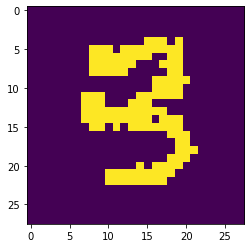

In [37]:
import matplotlib.pyplot as plt

plt.imshow(tf.squeeze(generated_samples.astype('uint8')[1]))

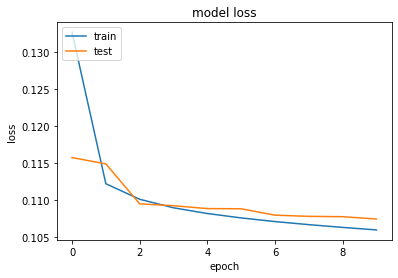

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
save_images((generated_samples*255).astype('uint8'), 28,28,10,10,epoch=10)

<PIL.Image.Image image mode=L size=280x280 at 0x7FC6E08874E0>


In [0]:
occluded_sample = next(iter(val_dataset.take(1)))[0]

In [0]:
occluded_sample = np.array(occluded_sample[:10])

In [127]:
occluded_sample.shape

(10, 28, 28, 1)

In [0]:
occluded_sample[:,19:,:,:] = 0

In [0]:
def generate_occluded(model, occluded_image, occl_row=None):
    if not occl_row:
        print("Specify the occlusion region by passing occl_row, which indicates the first row index under which an occlusion happens")
  
    import copy
    clone = copy.deepcopy(occluded_image)
  
    for i in range(28-occl_row):
        for j in range(28):
            occluded_image[:, occl_row+i,j, :] = binarize(model(occluded_image).numpy())[:,occl_row+i,j,:]

    return clone, occluded_image

In [0]:
occ, gen = generate_occluded(pixelcnn,occluded_sample, 19 )

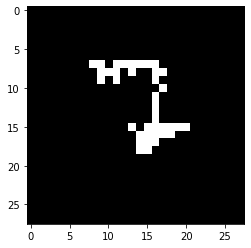

In [131]:
plt.imshow(occ[4,:,:,0]*255, cmap='gray', vmin=0, vmax=255)

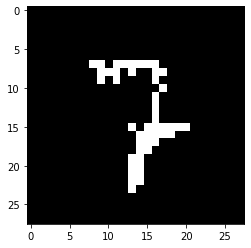

In [132]:
plt.imshow(gen[4,:,:,0]*255, cmap='gray', vmin=0, vmax=255)

In [0]:
def save_images_completion(occluded, completion, height, width, batch_size,
                           directory="./", prefix="completion", epoch=1):
    occluded = np.expand_dims(np.squeeze(occluded, axis=-1), axis=0)
    completion = np.expand_dims(np.squeeze(completion, axis=-1), axis=0)
    images = np.concatenate((occluded, completion), axis=0)
    images = images.transpose(0, 2, 1, 3)
    images = images.reshape((height * 2, width * batch_size))

    filename = '%s_%s.jpg' % (prefix, epoch)
    PIL.Image.fromarray(images.astype('uint8'), mode='L').save(os.path.join(directory, filename))

In [133]:
save_images_completion((occ*255).astype('uint8'),(gen*255).astype('uint8'),28,28,10,epoch=10)

<PIL.Image.Image image mode=L size=280x56 at 0x7FC6DF87FC50>
